# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

# Eval Function - 3 Model Evaluation: MAPE (old), RMSE(old), MDA(new)

In [2]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

def eval(test,pred):
  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_mda = calculate_mda(test, pred)
  print('MDE: ', test_mda)

In [3]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [4]:
def train_test(data):
    test_size = 0.3  # Thay đổi test_size thành 0.3 để có tỉ lệ 7:3

    test_split_idx = int(data.shape[0] * (1 - test_size))

    return data[:test_split_idx], data[test_split_idx:]

# ACB


## Data

In [5]:
df_amz = pd.read_csv("ACB Historical Data.csv")
df_amz

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"10,537.70","10,477.80","10,567.60","10,417.90",7.36M,0.86%
1,12/4/2017,"10,926.90","10,537.70","10,956.80","10,537.70",9.45M,3.69%
2,12/5/2017,"10,477.80","10,956.80","10,956.80","10,477.80",8.19M,-4.11%
3,12/6/2017,"10,447.90","10,447.90","10,627.50","10,328.10",9.81M,-0.29%
4,12/7/2017,"10,837.10","10,447.90","10,837.10","10,447.90",8.30M,3.73%
...,...,...,...,...,...,...,...
1506,12/18/2023,"22,800.00","22,700.00","22,800.00","22,650.00",6.39M,0.22%
1507,12/19/2023,"23,050.00","22,800.00","23,100.00","22,800.00",11.47M,1.10%
1508,12/20/2023,"23,200.00","23,050.00","23,250.00","23,050.00",8.86M,0.65%
1509,12/21/2023,"23,250.00","23,200.00","23,250.00","23,050.00",7.08M,0.22%


## Preprocessing

### Check null and na value

In [6]:
df_amz.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [7]:
df_amz.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [8]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_amz["Vol."] = df_amz["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_amz["Change %"] = df_amz["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_amz['Price'] = df_amz['Price'].apply(convert_str_to_number)
df_amz['Open'] = df_amz['Open'].apply(convert_str_to_number)
df_amz['High'] = df_amz['High'].apply(convert_str_to_number)
df_amz['Low'] = df_amz['Low'].apply(convert_str_to_number)

In [9]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Price column data type: ", type(df_amz['Price'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Vol. column data type: ", type(df_amz['Vol.'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [10]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [11]:
close_amz=df_amz[['Price']]

## EDA

### Get the duration of dataset

In [12]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

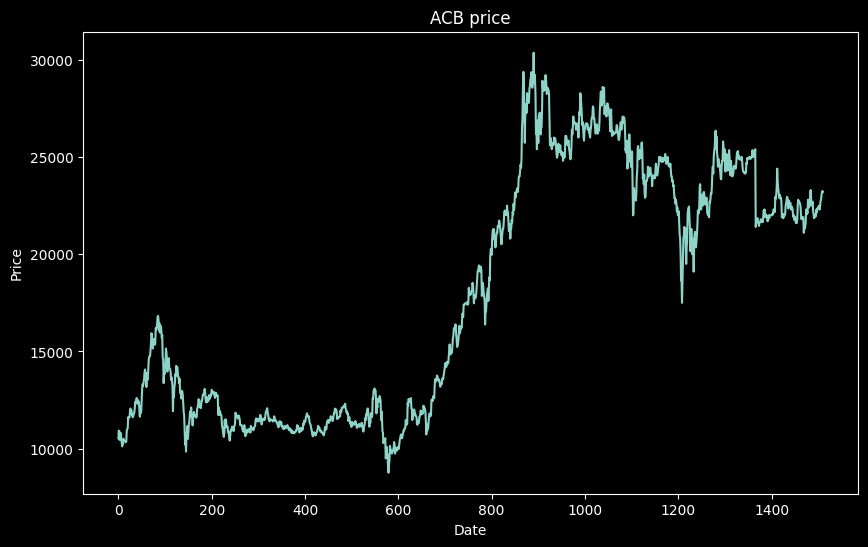

In [13]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_amz)
plt.title('ACB price')
plt.show()

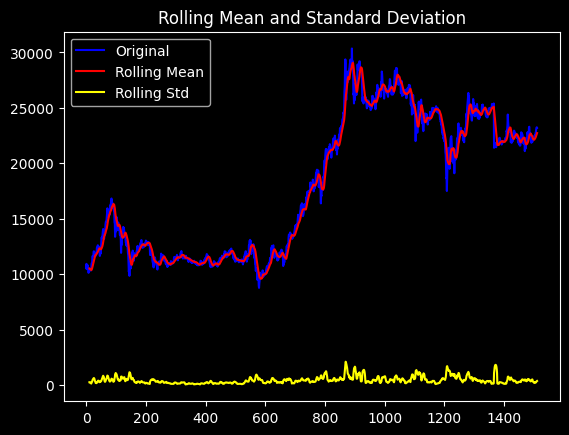

Results of dickey fuller test
Test Statistics                  -1.291961
p-value                           0.632842
No. of lags used                  3.000000
Number of observations used    1507.000000
critical value (1%)              -3.434697
critical value (5%)              -2.863460
critical value (10%)             -2.567792
dtype: float64


In [14]:
test_stationarity(close_amz)

## Train, test

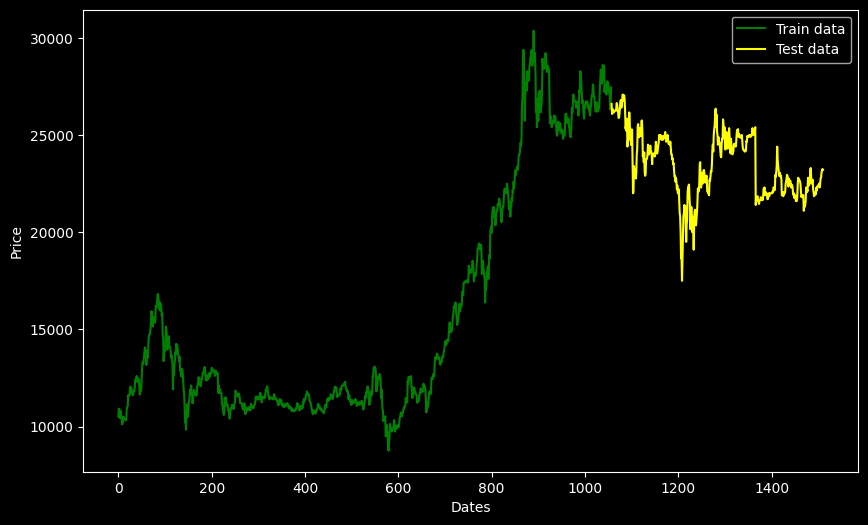

In [15]:
close_amz = close_amz.reset_index(drop=True)

#train_data, test_data, valid_data = train_test_valid(close_amz)
train_data, test_data = train_test(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
#plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [16]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [17]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23574.161, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15351.716, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15345.723, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15344.450, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=15345.818, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15344.304, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15344.452, Time=0.37 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=15346.296, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=15346.298, Time=0.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=15345.671, Time=0.40 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1057
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7666.152
Date:                Sat, 23 Dec 2023   AIC                          15344.304
Time:                        11:56:03   BIC                          15374.083
Sample:                             0   HQIC                         15355.592
                               - 1057                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4435      0.052     -8.565      0.000      -0.545      -0.342
ar.L2          0.5496      0.031     17.938      0.000       0.490       0.610
ar.L3          0.8934      0.050     17.795      0.000       0.795       0.992
ma.L1          1.4102      0.053     26.361      0.000       1.305       1.515
ma.L2          0.8963      0.048     18.569      0.000       0.802       0.991
sigma2      1.161e+05   2621.418     44.295      0.000    1.11e+05    1.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1501.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [18]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1057
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6794.658
Date:                Sat, 23 Dec 2023   AIC                          13603.316
Time:                        11:56:04   BIC                          13638.059
Sample:                             0   HQIC                         13616.485
                               - 1057                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8700     13.643     -0.797      0.426     -37.609      15.869
High           0.8380      0.013     63.526      0.000       0.812       0.864
Open          -0.6027      0.015    -40.275      0.000      -0.632      -0.573
Low            0.7646      0.012     64.124      0.000       0.741       0.788
ar.L1         -0.3471      0.154     -2.254      0.024      -0.649      -0.045
ma.L1          0.2050      0.163      1.259      0.208      -0.114       0.524
sigma2      2.253e+04    529.181     42.566      0.000    2.15e+04    2.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4107.14
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [19]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [20]:
eval(y_test,y_pred)

MAPE:  0.5964872899366975
RMSE:  188.30700369425367
MDE:  69.09492273730685


## Forecast

In [21]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_amz[['High','Open','Low']][last_index-484:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1511    22439.579240
1512    22371.211583
1513    22813.759973
1514    23367.365767
1515    23247.588441
1516    22736.628571
1517    22656.400814
1518    22647.653967
1519    22581.466291
1520    22346.227776
1521    21904.373488
1522    21925.691437
1523    21901.401732
1524    22280.013175
1525    22169.747547
1526    21830.854095
1527    22333.673573
1528    22221.227965
1529    22147.708571
1530    22377.822274
1531    22435.913382
1532    22325.647754
1533    22363.879866
1534    22375.642293
1535    22603.505266
1536    22757.919595
1537    22732.214760
1538    23038.027837
1539    23204.204592
1540    23113.797959
Name: predicted_mean, dtype: float64


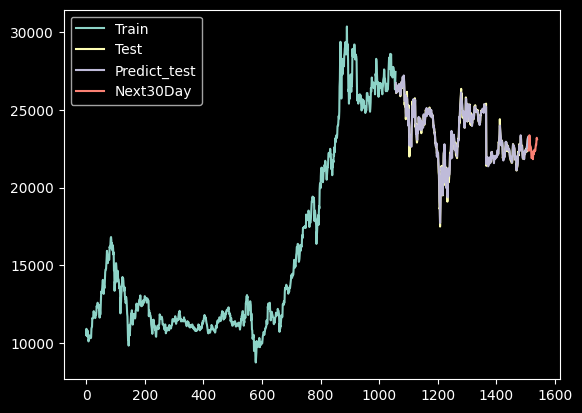

In [22]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# PVS

## Data

In [23]:
df_PVS = pd.read_csv("PVS Historical Data.csv")
df_PVS

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"17,292.00","16,746.00","17,474.00","16,655.00",12.03M,4.40%
1,12/4/2017,"17,838.00","17,383.00","17,838.00","17,383.00",6.60M,3.16%
2,12/5/2017,"17,292.00","18,020.00","18,020.00","17,292.00",6.46M,-3.06%
3,12/6/2017,"17,565.00","17,201.00","17,656.00","16,837.00",8.73M,1.58%
4,12/7/2017,"17,110.00","17,383.00","17,474.00","17,019.00",6.10M,-2.59%
...,...,...,...,...,...,...,...
1511,12/18/2023,"37,400.00","37,500.00","38,000.00","37,400.00",1.84M,-0.27%
1512,12/19/2023,"37,900.00","37,600.00","37,900.00","37,100.00",2.54M,1.34%
1513,12/20/2023,"38,400.00","37,900.00","38,600.00","37,900.00",3.04M,1.32%
1514,12/21/2023,"38,200.00","37,400.00","38,700.00","37,400.00",1.44M,-0.52%


## Preprocessing

### Check null and na value

In [24]:
df_PVS.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [25]:
df_PVS.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [26]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_PVS["Vol."] = df_PVS["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_PVS["Change %"] = df_PVS["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_PVS['Price'] = df_PVS['Price'].apply(convert_str_to_number)
df_PVS['Open'] = df_PVS['Open'].apply(convert_str_to_number)
df_PVS['High'] = df_PVS['High'].apply(convert_str_to_number)
df_PVS['Low'] = df_PVS['Low'].apply(convert_str_to_number)

In [27]:
print("Date column data type: ", type(df_PVS['Date'][0]))
print("Open column data type: ", type(df_PVS['Open'][0]))
print("Price column data type: ", type(df_PVS['Price'][0]))
print("High column data type: ", type(df_PVS['High'][0]))
print("Low column data type: ", type(df_PVS['Low'][0]))
print("Vol. column data type: ", type(df_PVS['Vol.'][0]))
print("Volume column data type: ", type(df_PVS['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [28]:
df_PVS['Date'] = pd.to_datetime(df_PVS.Date)

### Choose X

In [29]:
close_PVS=df_PVS[['Price']]

## EDA

### Get the duration of dataset

In [30]:
print("Starting date: ",df_PVS.iloc[0][0])
print("Ending date: ", df_PVS.iloc[-1][0])
print("Duration: ", df_PVS.iloc[-1][0]-df_PVS.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

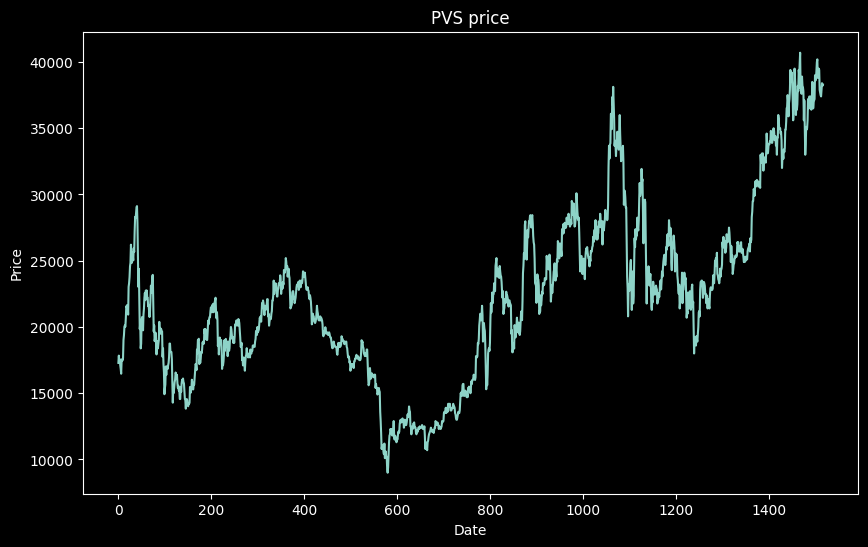

In [31]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_PVS)
plt.title('PVS price')
plt.show()

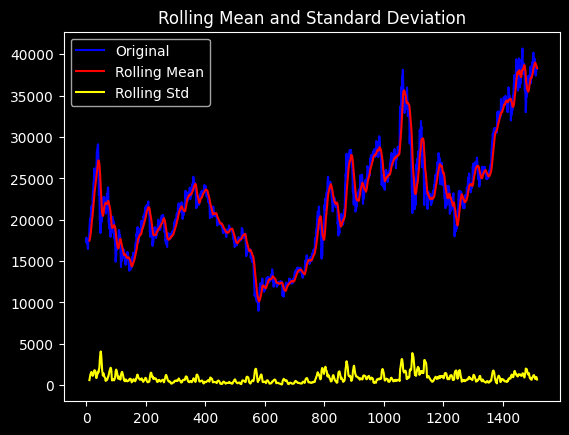

Results of dickey fuller test
Test Statistics                  -1.541720
p-value                           0.512781
No. of lags used                  0.000000
Number of observations used    1515.000000
critical value (1%)              -3.434674
critical value (5%)              -2.863450
critical value (10%)             -2.567787
dtype: float64


In [32]:
test_stationarity(close_PVS)

## Train, test

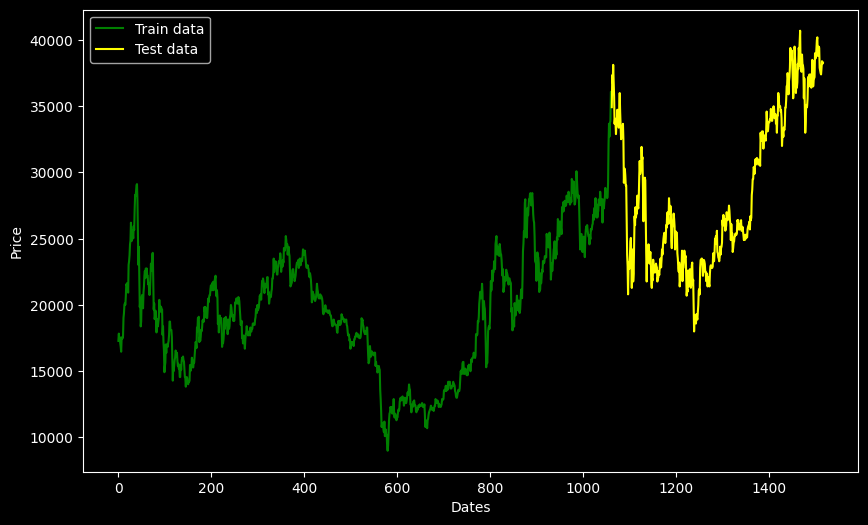

In [33]:
close_PVS = close_PVS.reset_index(drop=True)

train_data, test_data= train_test(close_PVS)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [34]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [35]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_PVS[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24049.144, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=22619.504, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16684.204, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16684.927, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=21433.913, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16681.995, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19717.037, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=16682.531, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21001.271, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1061
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8336.998
Date:                Sat, 23 Dec 2023   AIC                          16681.995
Time:                        11:56:08   BIC                          16701.863
Sample:                             0   HQIC                         16689.525
                               - 1061                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     75.5404     89.053      0.848      0.396     -99.001     250.082
ar.L1          0.9965      0.004    257.775      0.000       0.989       1.004
ma.L1         -0.0069      0.022     -0.308      0.758      -0.051       0.037
sigma2      3.902e+05   1.11e+04     35.025      0.000    3.68e+05    4.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               401.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.20
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [36]:
model = ARIMA(y_train, order=(3,0,2),exog=df_PVS[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1061
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7452.199
Date:                Sat, 23 Dec 2023   AIC                          14924.397
Time:                        11:56:10   BIC                          14974.067
Sample:                             0   HQIC                         14943.221
                               - 1061                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.3624     31.876      3.996      0.000      64.887     189.838
High           0.7839      0.014     56.097      0.000       0.756       0.811
Open          -0.5813      0.015    -39.205      0.000      -0.610      -0.552
Low            0.7888      0.014     57.617      0.000       0.762       0.816
ar.L1         -0.1122      1.898     -0.059      0.953      -3.832       3.608
ar.L2         -0.0038      0.917     -0.004      0.997      -1.800       1.793
ar.L3         -0.0214      0.237     -0.090      0.928      -0.486       0.443
ma.L1         -0.1147      1.899     -0.060      0.952      -3.838       3.608
ma.L2         -0.0011      1.234     -0.001      0.999      -2.419       2.417
sigma2      7.363e+04   2119.229     34.743      0.000    6.95e+04    7.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               400.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.35
Prob(H) (two-sided):                  0.25   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [37]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_PVS[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [38]:
eval(y_test,y_pred)

MAPE:  1.3201794284807156
RMSE:  483.2673979958119
MDE:  67.40088105726872


## Forecast

In [39]:
last_index =  close_PVS.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_PVS[['High','Open','Low']][last_index-485:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1516    36649.819307
1517    36860.965892
1518    37558.580620
1519    37339.063771
1520    36865.092711
1521    36375.212403
1522    36128.641002
1523    37569.731970
1524    37979.040606
1525    37383.456880
1526    36389.171842
1527    37141.760001
1528    36827.718087
1529    38752.496111
1530    39024.919957
1531    38864.015906
1532    39360.687497
1533    40462.254933
1534    39253.405098
1535    38640.482816
1536    38611.738706
1537    39025.894861
1538    38634.899687
1539    37788.755320
1540    37897.500075
1541    37757.346747
1542    37617.680870
1543    37244.538706
1544    38249.891518
1545    38224.526524
Name: predicted_mean, dtype: float64


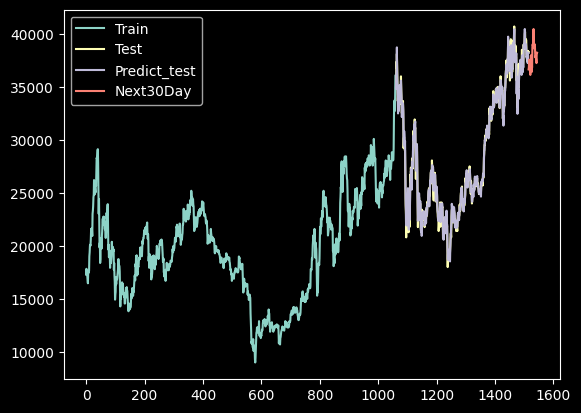

In [40]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()

# VNM

## Data

In [41]:
df_VNM = pd.read_csv("VNM Historical Data.csv")
df_VNM

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,"159,039.00","151,736.00","159,039.00","151,736.00",1.50M,4.98%
1,12/4/2017,"164,719.00","159,039.00","166,423.00","159,039.00",1.70M,3.57%
2,12/5/2017,"161,473.00","164,719.00","166,342.00","160,662.00",852.08K,-1.97%
3,12/6/2017,"158,227.00","158,227.00","159,850.00","151,898.00",1.14M,-2.01%
4,12/7/2017,"150,924.00","158,227.00","160,580.00","150,924.00",1.43M,-4.62%
...,...,...,...,...,...,...,...
1509,12/18/2023,"67,000.00","68,100.00","68,200.00","67,000.00",3.51M,-1.62%
1510,12/19/2023,"67,000.00","67,100.00","67,400.00","66,300.00",3.06M,0.00%
1511,12/20/2023,"68,100.00","67,000.00","68,200.00","67,000.00",2.60M,1.64%
1512,12/21/2023,"67,800.00","67,900.00","68,300.00","67,800.00",2.59M,-0.44%


## Preprocessing

### Check null and na value

In [42]:
df_VNM.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [43]:
df_VNM.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### Check datatype of each column

In [44]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df_VNM["Vol."] = df_VNM["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df_VNM["Change %"] = df_VNM["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df_VNM['Price'] = df_VNM['Price'].apply(convert_str_to_number)
df_VNM['Open'] = df_VNM['Open'].apply(convert_str_to_number)
df_VNM['High'] = df_VNM['High'].apply(convert_str_to_number)
df_VNM['Low'] = df_VNM['Low'].apply(convert_str_to_number)

In [45]:
print("Date column data type: ", type(df_VNM['Date'][0]))
print("Open column data type: ", type(df_VNM['Open'][0]))
print("Price column data type: ", type(df_VNM['Price'][0]))
print("High column data type: ", type(df_VNM['High'][0]))
print("Low column data type: ", type(df_VNM['Low'][0]))
print("Vol. column data type: ", type(df_VNM['Vol.'][0]))
print("Volume column data type: ", type(df_VNM['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Price column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Vol. column data type:  <class 'numpy.int64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_VNM['Date'] = pd.to_datetime(df_VNM.Date)

### Choose X

In [47]:
close_VNM=df_VNM[['Price']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_VNM.iloc[0][0])
print("Ending date: ", df_VNM.iloc[-1][0])
print("Duration: ", df_VNM.iloc[-1][0]-df_VNM.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-12-22 00:00:00
Duration:  2212 days 00:00:00


### Visualize the per day closing price of the stock

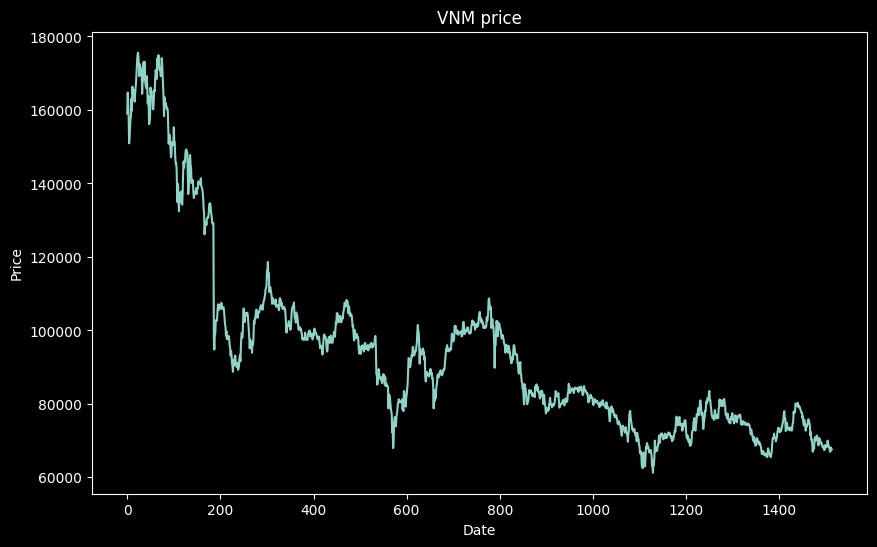

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(close_VNM)
plt.title('VNM price')
plt.show()

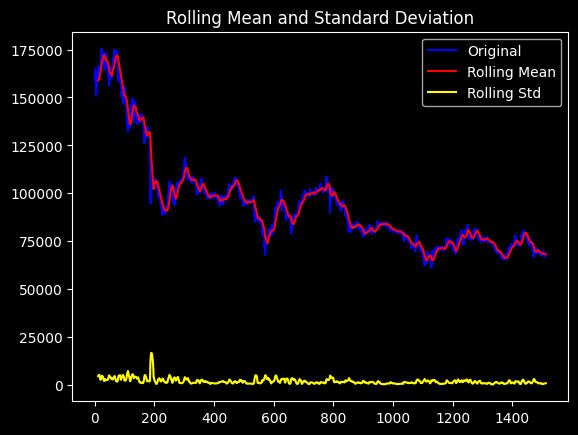

Results of dickey fuller test
Test Statistics                  -2.360615
p-value                           0.153162
No. of lags used                  0.000000
Number of observations used    1513.000000
critical value (1%)              -3.434679
critical value (5%)              -2.863452
critical value (10%)             -2.567788
dtype: float64


In [50]:
test_stationarity(close_VNM)

## Train, test

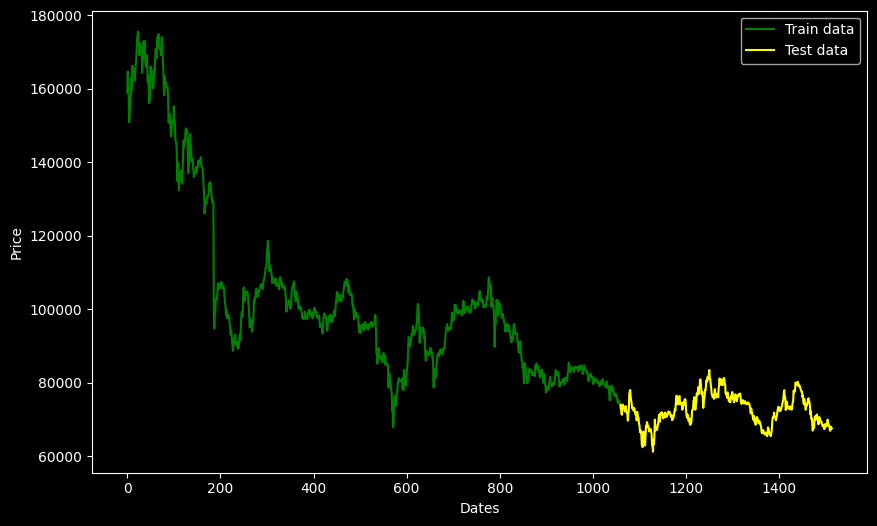

In [51]:
close_VNM = close_VNM.reset_index(drop=True)

train_data, test_data = train_test(close_VNM)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'yellow', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_VNM[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

C:\Users\20520\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27525.877, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19078.467, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19077.720, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19079.814, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19081.456, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19080.724, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=19084.518, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19076.664, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19078.622, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=19078.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1059
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -9533.332
Date:                Sat, 23 Dec 2023   AIC                          19076.664
Time:                        11:56:15   BIC                          19101.489
Sample:                             0   HQIC                         19086.073
                               - 1059                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    440.8669    509.099      0.866      0.387    -556.949    1438.682
ar.L1          0.0393      0.048      0.828      0.408      -0.054       0.132
ar.L2          0.9567      0.048     20.119      0.000       0.863       1.050
ma.L1          0.9431      0.056     16.840      0.000       0.833       1.053
sigma2      3.794e+06      0.477   7.96e+06      0.000    3.79e+06    3.79e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):            186856.73
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -3.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+22. Standard errors may be unstable.
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1),exog=df_VNM[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1059
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8331.460
Date:                Sat, 23 Dec 2023   AIC                          16676.920
Time:                        11:56:15   BIC                          16711.676
Sample:                             0   HQIC                         16690.093
                               - 1059                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.9794     69.930     -0.300      0.764    -158.040     116.081
High           0.8117      0.012     65.202      0.000       0.787       0.836
Open          -0.6060      0.013    -45.067      0.000      -0.632      -0.580
Low            0.7941      0.011     70.323      0.000       0.772       0.816
ar.L1         -0.6555      0.153     -4.273      0.000      -0.956      -0.355
ma.L1          0.5904      0.161      3.659      0.000       0.274       0.907
sigma2      3.837e+05      0.012   3.19e+07      0.000    3.84e+05    3.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               637.25
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.74e+23. Standard errors may be unstable.
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_VNM[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])

In [56]:
eval(y_test,y_pred)

MAPE:  0.5260602064386073
RMSE:  504.91378111147543
MDE:  77.5330396475771


## Forecast

In [57]:
last_index =  close_VNM.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_VNM[['High','Open','Low']][last_index-485:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1514    69808.667882
1515    69031.855714
1516    68651.424942
1517    71422.821087
1518    70573.947595
1519    69613.332708
1520    69571.338433
1521    69289.553955
1522    69633.036966
1523    68969.492647
1524    68011.535900
1525    68025.726494
1526    67910.465041
1527    68467.424838
1528    67811.585172
1529    68129.886451
1530    69194.427720
1531    68289.135783
1532    68468.089373
1533    67729.751422
1534    68775.055583
1535    69985.196907
1536    69248.852560
1537    68451.905175
1538    68609.197092
1539    68225.677221
1540    67269.911464
1541    66670.723816
1542    67936.544882
1543    68107.560244
Name: predicted_mean, dtype: float64


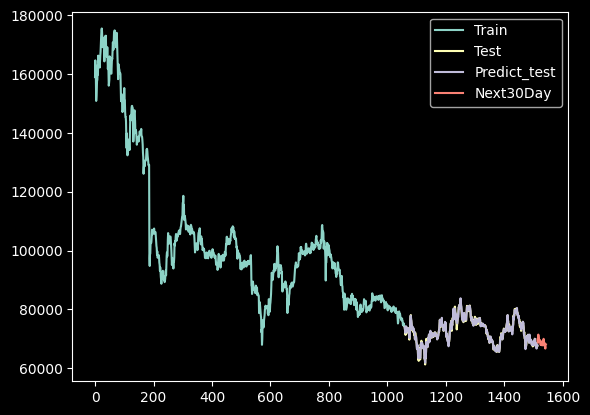

In [58]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()